In [22]:
from transformers import AutoTokenizer, AutoModel, utils
import torch
from torch import tensor
from bertviz import model_view
utils.logging.set_verbosity_error()  # Suppress standard warnings
import difflib
import numpy as np

def find_first_element_in_list(element, array_list, begin_idx=0):
        for idx in range(begin_idx, len(array_list)):
            if array_list[idx] == element:
                return idx
        return -1

def find_diff_indexes_in_arrays(array, array_pair, item_real_begin_index=0, item_pair_real_begin_index=0):
    # convert int array to strin array
    array = [str(a) for a in array]
    array_pair = [str(a) for a in array_pair]

    # Creating a Differ object
    d = difflib.Differ()

    # Calculating the difference
    diff = list(d.compare(array, array_pair))
    # print(diff)
    # # Extracting the index of changing words
    # changes = [i for i, word in enumerate(diff) if word.startswith("+ ") or word.startswith("- ")]

    i, j = 0, 0
    old_diff = []
    new_diff = []
    for idx, word in enumerate(diff):
        if word.startswith("+"):
            new_diff.append(i)
            i += 1
        elif word.startswith("-"):
            old_diff.append(j)
            j += 1
        else:
            i += 1
            j += 1

    return old_diff, new_diff

def process_attention_weight(tokenizer, input_ids):
    attetion_masks = []
    for i, ids in enumerate(input_ids):
        sep_idx1 = find_first_element_in_list(tokenizer.sep_token_id, ids, begin_idx=0)
        array = ids[1:sep_idx1]

        sep_idx2 = find_first_element_in_list(tokenizer.sep_token_id, ids, begin_idx=sep_idx1+1)
        array_pair = ids[sep_idx1+1:sep_idx2]
            
        temp_old_diff, temp_new_diff = find_diff_indexes_in_arrays(array, array_pair)
        old_diff = [idx+1 for idx in temp_old_diff]
        new_diff = [idx+sep_idx1+1 for idx in temp_new_diff]
        changes = old_diff + new_diff

        atte_mask = []
        for idx in range(len(ids)):
            if idx in changes:
                atte_mask.append(1)
            elif ids[idx] == tokenizer.pad_token_id:
                atte_mask.append(0)
            else:
                atte_mask.append(0.5)
        attetion_masks.append(atte_mask)

    return attetion_masks



In [23]:
model_name = "./checkpoints/checkpoints2402191335"  # Find popular HuggingFace models here: https://huggingface.co/models
# input_text = "The cat sat on the mat"  
old_snippet = "Less likely to cause problems is the minimum size for shared memory segments (SHMMIN), which should be at most approximately 500 kB for PostgreSQL (it is usually just 1)."
new_snippet = "Less likely to cause problems is the minimum size for shared memory segments (SHMMIN), which should be at most approximately 32 bytes for PostgreSQL (it is usually just 1). The maximum number of segments system-wide (SHMMNI) or per-process (SHMSEG) are unlikely to cause a problem unless your system has them set to zero."
model = AutoModel.from_pretrained(model_name, output_attentions=True)  # Configure model to return attention values
tokenizer = AutoTokenizer.from_pretrained(model_name, max_length=512, padding='max_length')


In [24]:
inputs = tokenizer(old_snippet, new_snippet, return_tensors='pt')  # Tokenize input text
inputs = {k: v.to(model.device) for k,v in inputs.items()}
print(inputs)
print("default attention", inputs['attention_mask'])
# inputs['attention_mask'] = tensor(process_attention_weight(tokenizer, inputs['input_ids']))
# print("updated attention", inputs['attention_mask'])

{'input_ids': tensor([[  101, 13568,  2620,  1106,  2612,  2645,  1110,  1103,  5867,  2060,
          1111,  3416,  2962,  9038,   113, 17730, 25290, 11607,   114,   117,
          1134,  1431,  1129,  1120,  1211,  2324,  2260,   180,  2064,  1111,
          3799,  1403,  1874,  1708, 22825,   113,  1122,  1110,  1932,  1198,
           122,   114,   119,   102, 13568,  2620,  1106,  2612,  2645,  1110,
          1103,  5867,  2060,  1111,  3416,  2962,  9038,   113, 17730, 25290,
         11607,   114,   117,  1134,  1431,  1129,  1120,  1211,  2324,  2724,
          1118,  3052,  1111,  3799,  1403,  1874,  1708, 22825,   113,  1122,
          1110,  1932,  1198,   122,   114,   119,  1109,  4177,  1295,  1104,
          9038,  1449,   118,  2043,   113, 17730, 25290, 27451,   114,  1137,
          1679,   118,  1965,   113, 17730,  7182, 17020,   114,  1132,  9803,
          1106,  2612,   170,  2463,  4895,  1240,  1449,  1144,  1172,  1383,
          1106,  6756,   119,   102]])

In [25]:
outputs = model(**inputs)  # Run model
attention = outputs[-1]  # Retrieve attention from model outputs
len(attention)

12

In [45]:
outputs

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-1.2390,  0.0689,  0.0792,  ..., -0.6901,  0.2246,  1.0708],
         [ 0.0772, -0.2605,  0.8639,  ..., -0.9644,  0.0400,  0.1563],
         [-0.0356,  0.8489,  0.3008,  ..., -0.6081,  0.1493,  0.2422],
         ...,
         [-0.6951,  1.2464, -0.2885,  ..., -0.0327,  0.0489,  0.7674],
         [-1.2402,  0.7786,  0.6625,  ..., -0.3779, -0.1039,  0.7768],
         [-1.2401,  0.6858,  0.7722,  ..., -0.3707, -0.1198,  0.7608]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-0.8051,  0.9065,  0.9999, -0.6369,  0.8837, -0.9954,  0.9974,  0.9992,
         -0.9074, -0.8537,  0.9898,  0.8996,  0.9914, -0.9998, -0.9778, -0.6382,
          0.9395, -0.4797, -0.9998,  0.9837,  0.4020, -0.9960, -0.0339, -0.9972,
          0.9798, -0.5099,  0.9753,  0.9975,  0.8962,  0.9004,  0.2944, -0.9648,
         -0.9892, -0.9979,  0.8793,  0.0484, -0.9785,  0.1450, -0.9923,  0.9536,
         -0.8845,  0.9803, -0.91

In [26]:
last_layer_attention = attention[-1] 
last_layer_attention.size()

torch.Size([1, 12, 124, 124])

In [27]:
attention_mean_across_heads = torch.mean(last_layer_attention, dim=1)  # Averaging across heads
attention_mean_across_heads.size()

torch.Size([1, 124, 124])

In [28]:
batch_attention = attention_mean_across_heads[0].cpu().detach().numpy()
np.shape(batch_attention)

(124, 124)

In [37]:
inputs['input_ids'].squeeze(0).size()


torch.Size([124])

In [47]:
tokenizer.decode(inputs['input_ids'].squeeze(0))

'[CLS] Less likely to cause problems is the minimum size for shared memory segments ( SHMMIN ), which should be at most approximately 500 kB for PostgreSQL ( it is usually just 1 ). [SEP] Less likely to cause problems is the minimum size for shared memory segments ( SHMMIN ), which should be at most approximately 32 bytes for PostgreSQL ( it is usually just 1 ). The maximum number of segments system - wide ( SHMMNI ) or per - process ( SHMSEG ) are unlikely to cause a problem unless your system has them set to zero. [SEP]'

In [1]:
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'].squeeze(0))  # Convert input ids to token strings
tokens

NameError: name 'tokenizer' is not defined

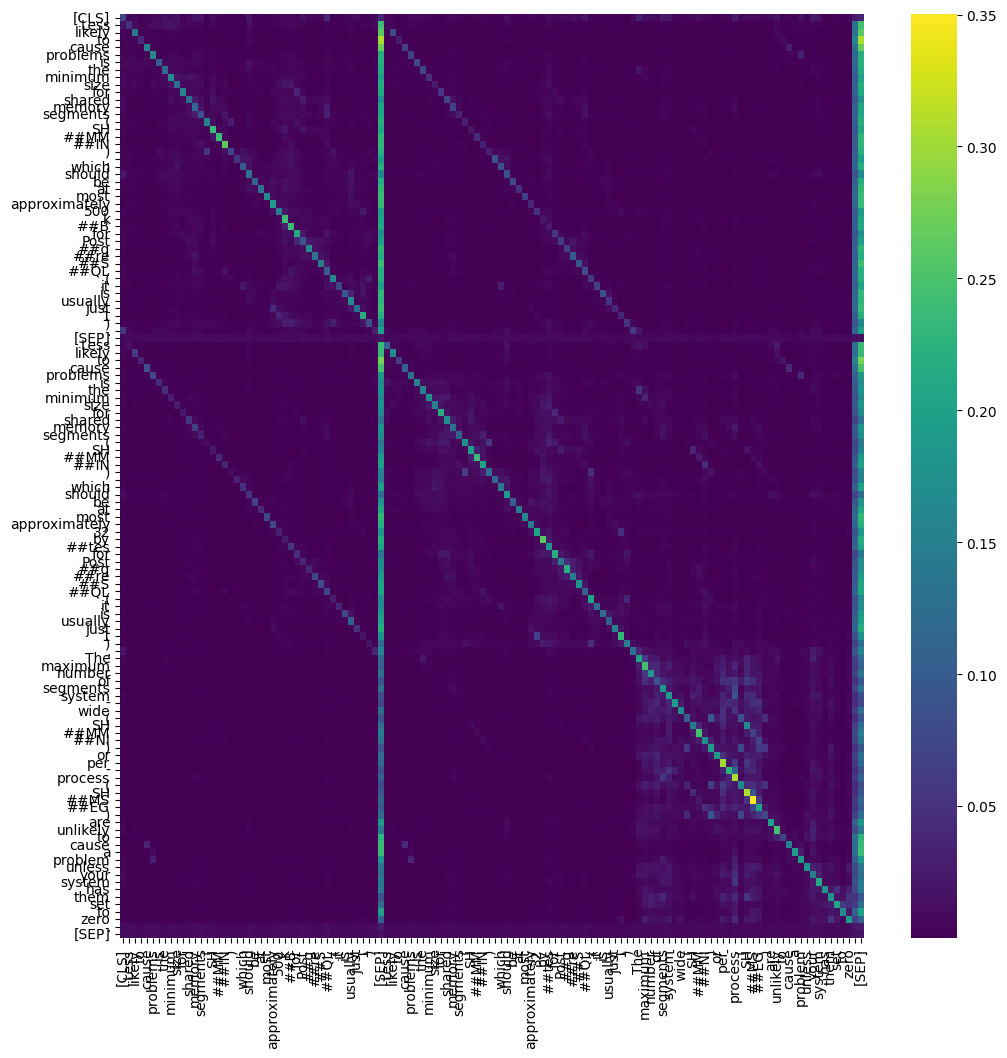

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 12))
sns.heatmap(batch_attention, xticklabels=tokens, yticklabels=tokens, cmap='viridis')
plt.show()

In [44]:
outputs

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-1.2390,  0.0689,  0.0792,  ..., -0.6901,  0.2246,  1.0708],
         [ 0.0772, -0.2605,  0.8639,  ..., -0.9644,  0.0400,  0.1563],
         [-0.0356,  0.8489,  0.3008,  ..., -0.6081,  0.1493,  0.2422],
         ...,
         [-0.6951,  1.2464, -0.2885,  ..., -0.0327,  0.0489,  0.7674],
         [-1.2402,  0.7786,  0.6625,  ..., -0.3779, -0.1039,  0.7768],
         [-1.2401,  0.6858,  0.7722,  ..., -0.3707, -0.1198,  0.7608]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-0.8051,  0.9065,  0.9999, -0.6369,  0.8837, -0.9954,  0.9974,  0.9992,
         -0.9074, -0.8537,  0.9898,  0.8996,  0.9914, -0.9998, -0.9778, -0.6382,
          0.9395, -0.4797, -0.9998,  0.9837,  0.4020, -0.9960, -0.0339, -0.9972,
          0.9798, -0.5099,  0.9753,  0.9975,  0.8962,  0.9004,  0.2944, -0.9648,
         -0.9892, -0.9979,  0.8793,  0.0484, -0.9785,  0.1450, -0.9923,  0.9536,
         -0.8845,  0.9803, -0.91

In [2]:
tokens_first_sentence = ['[CLS]', 'The', 'by', '##te', '##a', 'type', 'supports', 'two', 'external', 'formats', 'for', 'input', 'and', 'output', ':', 'Post', '##g', '##re', '##S', '##QL', "'", 's', 'historical', '"', 'escape', '"', 'format', ',', 'and', '"', 'he', '##x', '"', 'format', '.', 'Both', 'of', 'these', 'are', 'always', 'accepted', 'on', 'input', '.', 'The', 'output', 'format', 'depends', 'on', 'the', 'configuration', 'parameter', 'by', '##te', '##a', '_', 'output', ';', 'the', 'default', 'is', 'he', '##x', '.', '(', 'Note', 'that', 'the', 'he', '##x', 'format', 'was', 'introduced', 'in', 'Post', '##g', '##re', '##S', '##QL', '9', '.', '0', ';', 'earlier', 'versions', 'and', 'some', 'tools', 'don', "'", 't', 'understand', 'it', '.', ')', '[SEP]']
attention_first_sentence = [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.040486905723810196], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.06403592973947525], [0.08676686137914658], [0.05043145641684532], [0.04673025757074356], [0.05356588214635849], [0.043722353875637054], [0.06418517976999283], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
tokens_second_sentence = ['[SEP]', 'The', 'by', '##te', '##a', 'type', 'supports', 'two', 'formats', 'for', 'input', 'and', 'output', ':', '"', 'he', '##x', '"', 'format', 'and', 'Post', '##g', '##re', '##S', '##QL', "'", 's', 'historical', '"', 'escape', '"', 'format', '.', 'Both', 'of', 'these', 'are', 'always', 'accepted', 'on', 'input', '.', 'The', 'output', 'format', 'depends', 'on', 'the', 'configuration', 'parameter', 'by', '##te', '##a', '_', 'output', ';', 'the', 'default', 'is', 'he', '##x', '.', '(', 'Note', 'that', 'the', 'he', '##x', 'format', 'was', 'introduced', 'in', 'Post', '##g', '##re', '##S', '##QL', '9', '.', '0', ';', 'earlier', 'versions', 'and', 'some', 'tools', 'don', "'", 't', 'understand', 'it', '.', ')', '[SEP]']
attention_second_sentence = [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.09943615645170212], [0.07817292213439941], [0.10603168606758118], [0.09348487108945847], [0.09848490357398987], [0.07446467876434326], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df1 = pd.DataFrame(attention_first_sentence)
df2 = pd.DataFrame(attention_second_sentence)

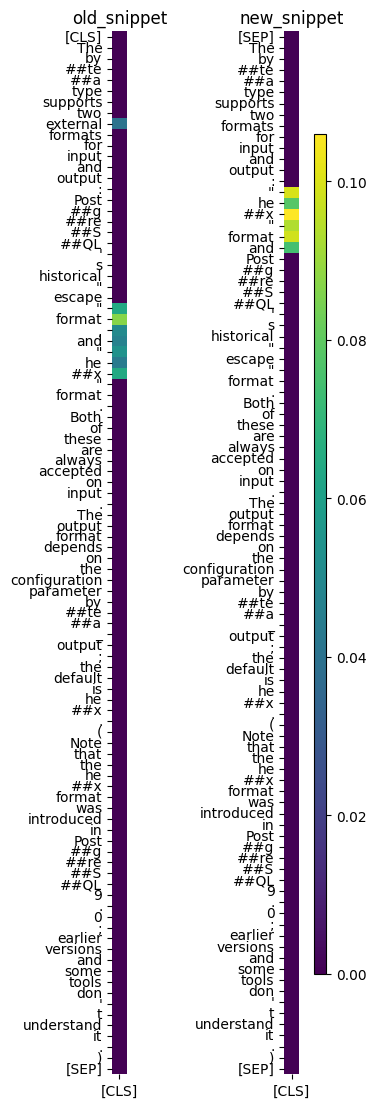

In [15]:
# Determine the global min and max of the data for both heatmaps to use the same color scale
vmin = min(df1.values.min(), df2.values.min())
vmax = max(df1.values.max(), df2.values.max())

# Create a figure to hold the subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(4, 12))

# Increase the space between the heatmaps
plt.subplots_adjust(hspace=max(len(tokens_first_sentence), len(tokens_second_sentence)) / 1)  # Adjust the vertical space between plots

# Plot the first heatmap
sns.heatmap(df1, ax=axs[0], cmap="viridis", yticklabels=tokens_first_sentence, xticklabels=['[CLS]'],  vmin=vmin, vmax=vmax, cbar=False)
axs[0].set_title('old_snippet')

# Plot the second heatmap
heatmap2 = sns.heatmap(df2, ax=axs[1], cmap="viridis", yticklabels=tokens_second_sentence, xticklabels=['[CLS]'], vmin=vmin, vmax=vmax, cbar=False)
axs[1].set_title('new_snippet')

# Adjust layout for the colorbar
plt.subplots_adjust(right=0.85, hspace=0.9)

plt.tight_layout(pad=4)

# Create a colorbar
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7]) # [left, bottom, width, height]
fig.colorbar(heatmap2.collections[0], cax=cbar_ax)

# Show the plot
plt.show()